# Running FEISTY with time-series forcing from CESM

Kristen produced a 1&deg; companion run to our high-res run, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper login node with 4 GB of memory.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client, wait
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [3]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_g17.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

## Set up Dask cluster

Since the data in `ds` is chunked in `nlat` and `nlon`, we use a `dask` cluster to configure the parallelization.
For running multiple years, I would recommend increasing the per-worker memory from 12 GB,
but a typical year tends to stay between 5 GB and 9 GB per worker.

In [4]:
mem = 12  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44915 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/44915/status,
Dashboard: proxy/44915/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:34872,Workers: 0
Dashboard: proxy/44915/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time

client.wait_for_workers(feisty_config['num_workers'])

CPU times: user 201 ms, sys: 24 ms, total: 225 ms
Wall time: 11.6 s


## Run the model

Currently, the `feisty-config.TL319_g17.4p2z.001.yml` is configured to run a single year (1958):

```yaml
start_date: '1958-01-01'
end_date: '1958-12-31'
```

And it is initialized from the last timestep of a 125 spin-up run:

```yaml
initial_conditions:
  root_dir: /glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/FEISTY_ic
  ic_file: companion_spinup.0125-12-31.zarr
```

In [6]:
%%time

# map_blocks lets us run in parallel over our dask cluster
ds_out = feisty.config_and_run_from_yaml(feisty_config)
ds_out["biomass"]

Starting template generation at 10:06:53


/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.29 MiB detected in task graph: 
  ([('forcing_time',), <xarray.IndexVariable 'forcin ... =object), {}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Removing ./companion_1958.zarr/ before writing new copy
Writing ./companion_1958.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Removing ./companion_1958-12-31.zarr/ before writing new copy
Writing ./companion_1958-12-31.zarr
Calling to_zarr...
CPU times: user 8.17 s, sys: 860 ms, total: 9.03 s
Wall time: 3min 6s


<xarray.DataArray 'biomass' (time: 365, group: 9, nlat: 384, nlon: 320)>
dask.array<biomass-config_and_run_from_dataset, shape=(365, 9, 384, 320), dtype=float64, chunksize=(365, 9, 128, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1958-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

### Plotting

Make a plot of `biomass` over time at a specified column.
This specific column was chosen somewhat randomly, and represents (7.7&deg; N, 137.3&deg; W).

CPU times: user 106 ms, sys: 7.53 ms, total: 113 ms
Wall time: 152 ms


Text(0.5, 1.0, 'Biomass at (215, 233)')

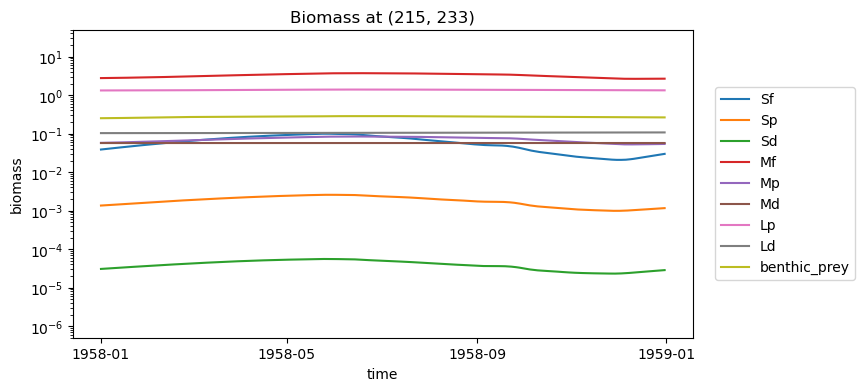

In [7]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-7, 50])
ax.set_yscale('log')
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
plt.title(f'Biomass at ({nlat}, {nlon})');

CPU times: user 64.9 ms, sys: 5.04 ms, total: 69.9 ms
Wall time: 113 ms


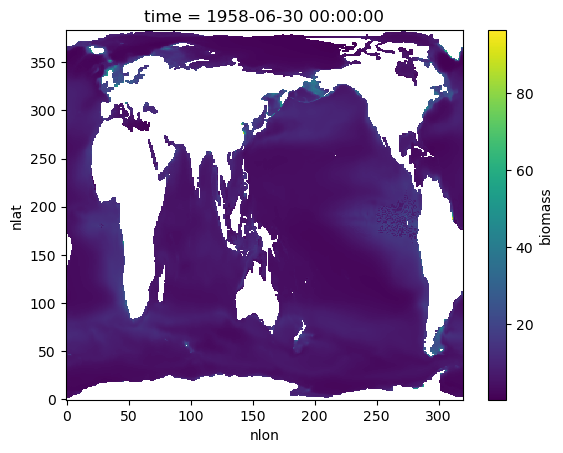

In [8]:
%%time

ds_out["biomass"].isel(time=180).sum('group', skipna=False).plot()

CPU times: user 61.3 ms, sys: 4.03 ms, total: 65.3 ms
Wall time: 72.1 ms


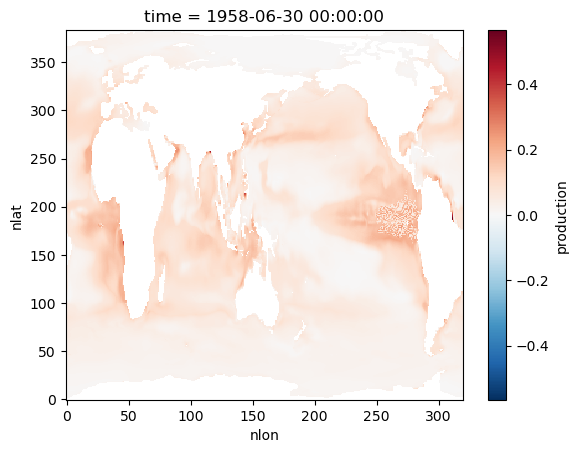

In [9]:
%%time

ds_out['production'].isel(time=180).sum('fish', skipna=False).plot()

CPU times: user 163 ms, sys: 14 ms, total: 177 ms
Wall time: 229 ms


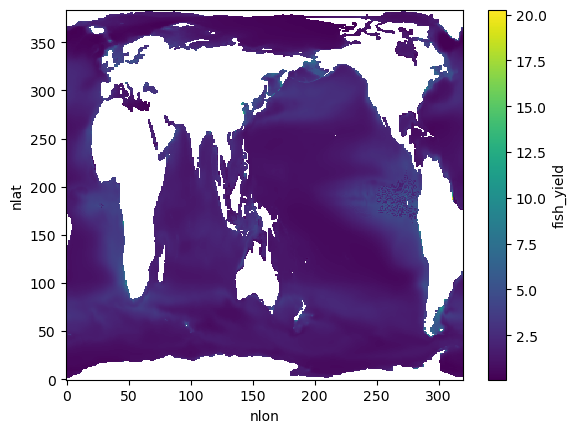

In [10]:
%%time

ds_out['fish_yield'].sum(
    ['time', 'fish'], skipna=False
).plot()  # .sum('time')/365 is average per day => .sum('time') [multiplying previous by 365] converts to per yr

In Petrik, et al. (2019), Figure 6 shows comparisons of fish yield between FEISTY and observations.
As a first pass at comparing to that plot, I computed the min and max of `log10(fish_yield)` for foragers,
large pelagics, demersals, and then all fish.
These numbers could be compared to the `y`-axis of the four panels in the aforementioned plot.

In [11]:
# Forage
forage_yield = (
    ds_out['fish_yield'].sel(fish=['Sf', 'Mf']).sum(['time', 'fish'], skipna=False).values
)
minmax = np.log10(np.array([np.nanmin(forage_yield), np.nanmax(forage_yield)]))
print(f'Forager yield ranges from {minmax[0]:.2f} to {minmax[1]:.2f} (log scale)')

# Large Pelagic
pelagic_yield = (
    ds_out['fish_yield'].sel(fish=['Sp', 'Mp', 'Lp']).sum(['time', 'fish'], skipna=False).values
)
minmax = np.log10(np.array([np.nanmin(pelagic_yield), np.nanmax(pelagic_yield)]))
print(f'Large pelagic yield ranges from {minmax[0]:.2f} to {minmax[1]:.2f} (log scale)')

# Demersal
demersal_yield = (
    ds_out['fish_yield'].sel(fish=['Sd', 'Md', 'Ld']).sum(['time', 'fish'], skipna=False).values
)
minmax = np.log10(np.array([np.nanmin(demersal_yield), np.nanmax(demersal_yield)]))
print(f'Demersal yield ranges from {minmax[0]:.2f} to {minmax[1]:.2f} (log scale)')

# Total
total_yield = ds_out['fish_yield'].sum(['time', 'fish'], skipna=False).values
minmax = np.log10(np.array([np.nanmin(total_yield), np.nanmax(total_yield)]))
print(f'Total yield ranges from {minmax[0]:.2f} to {minmax[1]:.2f} (log scale)')

Forager yield ranges from -68.39 to 0.52 (log scale)
Large pelagic yield ranges from -68.79 to 0.51 (log scale)
Demersal yield ranges from -3.07 to 1.23 (log scale)
Total yield ranges from -1.13 to 1.31 (log scale)
